In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
train_data, validation_data, test_data = tfds.load('deep_weeds', split=['train[:80%]', 'train[81%:90%]', 'train[91%:]'], as_supervised=True)

TARGET_SIZE = (128, 128)
TARGET_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

train_data = train_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))
validation_data = validation_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))
test_data = test_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))


#steps = 41
train_data = train_data.shuffle(1024) #.batch(150)
validation_data = validation_data.shuffle(1024) #.batch(25)


print("Number of training samples: %d" % tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_data))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_data))

Number of training samples: 14007
Number of validation samples: 1576
Number of test samples: 1576


tf.Tensor(
[[[[0.70980394 0.61960787 0.7078431 ]
   [0.74215686 0.68235296 0.7392157 ]
   [0.28627452 0.22647059 0.26862746]
   ...
   [0.4245098  0.4343137  0.36960784]
   [0.20294118 0.20490196 0.18529412]
   [0.29313725 0.29509804 0.31960785]]

  [[0.78431374 0.7205882  0.7823529 ]
   [0.45882353 0.3970588  0.4480392 ]
   [0.21470588 0.1627451  0.19509804]
   ...
   [0.5323529  0.5362745  0.4715686 ]
   [0.1627451  0.16470589 0.14509805]
   [0.20392157 0.2        0.2254902 ]]

  [[0.42843136 0.38333333 0.42156863]
   [0.34901962 0.3107843  0.34019607]
   [0.20294118 0.16568628 0.17843138]
   ...
   [0.5852941  0.5892157  0.52254903]
   [0.15588236 0.15392157 0.13039216]
   [0.15980393 0.15686275 0.1754902 ]]

  ...

  [[0.327451   0.27941176 0.31862745]
   [0.20490196 0.15588236 0.20392157]
   [0.21764706 0.16862746 0.2245098 ]
   ...
   [0.11666667 0.1245098  0.10490196]
   [0.12352941 0.12352941 0.11568628]
   [0.12843138 0.12843138 0.12058824]]

  [[0.28235295 0.24313726 0.274509

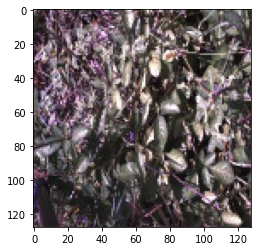

In [4]:
inputs = keras.Input(shape=TARGET_SHAPE)
normalizer = keras.layers.experimental.preprocessing.Normalization()
preprocess = normalizer(inputs)
normalizer.set_weights([np.array([0] * 3), np.array([255**2] * 3)])

image_batch, label_batch = next(iter(train_data))
test = normalizer(image_batch)
print(test)
print(label_batch)
plt.imshow(tf.reshape(test, (128, 128, 3)))

In [6]:
vgg_model = keras.applications.VGG19(include_top=False, weights='imagenet', pooling='avg', input_shape=TARGET_SHAPE)
vgg_model.trainable = False
#print(base_model.summary())
#img = train_data.take(1)
#print(img)
#image_batch, label_batch = next(iter(train_data))
#print(image_batch)
#plt.imshow(image_batch / 255.0)
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.GlobalAveragePooling2D(),
])

base_features = base_model(preprocess) 

vgg_features = vgg_model(preprocess)


features = keras.layers.Concatenate(axis=1)([base_features, vgg_features])

dense_layer = keras.layers.Dense(512,
                                     activation='relu',
                                     kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                     bias_regularizer=keras.regularizers.l2(1e-4),
                                     activity_regularizer=keras.regularizers.l2(1e-5)
                                    )
dropout = keras.layers.Dropout(0.25)
classifier_head = keras.layers.Dense(9, 
                                     activation='softmax',
                                    )
#outputs = classifier_head(dropout(features))
outputs = classifier_head(dropout(dense_layer(features)))
#outputs = classifier_head(dense_layer(features))
print(outputs.shape)

model = keras.Model(inputs, outputs)

print(model.summary())

(None, 9)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 128, 128, 3)  7           input_2[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 512)          1187328     normalization_1[0][0]            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 512)          20024384    normalization_1[0][0]            
_____________________________________________________________________________

In [10]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8)
mc = keras.callbacks.ModelCheckpoint('best_val_acc_combo.h5', monitor='val_sparse_categorical_accuracy', mode='max', save_best_only=True)


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy']   
)

#print(model.summary())
history2 = model.fit(train_data.batch(32)
, epochs=75
, validation_data=validation_data.batch(250)
, validation_steps=7
, steps_per_epoch=438
, callbacks=[es, mc]
)

model = keras.models.load_model('best_val_acc_combo.h5')

#model.load_weights('best_val_acc_w.h5')
#model.save_weights("classifier_head_weights.tf")

Epoch 1/75
438/438 [==============================] - 80s 183ms/step - loss: 0.7062 - sparse_categorical_accuracy: 0.7800 - val_loss: 0.6888 - val_sparse_categorical_accuracy: 0.7900
Epoch 2/75
438/438 [==============================] - 79s 180ms/step - loss: 0.6985 - sparse_categorical_accuracy: 0.7849 - val_loss: 0.7283 - val_sparse_categorical_accuracy: 0.7747
Epoch 3/75
438/438 [==============================] - 79s 180ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.7849 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.7817
Epoch 4/75
438/438 [==============================] - 78s 177ms/step - loss: 0.6878 - sparse_categorical_accuracy: 0.7860 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.7779
Epoch 5/75
438/438 [==============================] - 78s 177ms/step - loss: 0.6874 - sparse_categorical_accuracy: 0.7905 - val_loss: 0.7029 - val_sparse_categorical_accuracy: 0.7811
Epoch 6/75
438/438 [==============================] - 78s 177ms/step - loss: 0.6821 -

<Figure size 432x288 with 0 Axes>

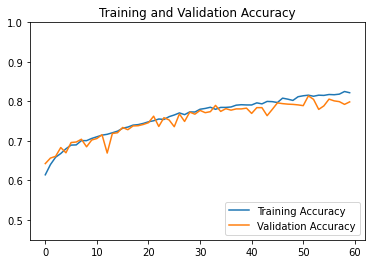

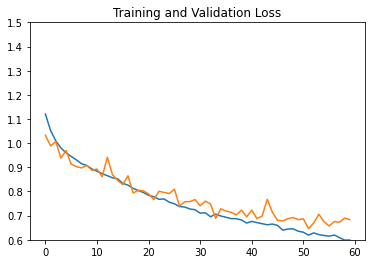

<Figure size 432x288 with 0 Axes>

In [14]:
%matplotlib inline
#print(history.history)

acc2=acc + history2.history['sparse_categorical_accuracy']
val_acc2= val_acc + history2.history['val_sparse_categorical_accuracy']
loss2=loss + history2.history['loss']
val_loss2=val_loss + history2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(acc2, label='Training Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.ylim([0.45, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure()


plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.ylim([0.6, 1.5])
#plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.figure()

In [12]:
tstloss, accuracy = model.evaluate(test_data.batch(100))
print(accuracy)

16/16 [==============================] - 3s 202ms/step - loss: 0.7383 - sparse_categorical_accuracy: 0.7906
0.7906091213226318


In [83]:
model = keras.models.load_model('best_val_acc_combo.h5')
#model.save_weights('best_val_acc_w.h5')
#model = keras.Model(input, outputs)
#model.load_weights('best_val_acc_w.h5')
#start fine tuning

#drop = keras.layers.Dropout(0.15)
#layers = [l for l in model.layers]
#x = layers[0].output
#for i in range(1, len(layers)):
#    if i == 3:
#        x = drop(x)
#    x = layers[i](x)

#model = keras.Model(layers[0].input, x)

base_model = model.layers[2]
print(len(base_model.layers))
base_model.trainable = True

#res net 101 has a crazy number of layers.  Look at the model summary to figure out what to unfreeze  
FINE_TUNE_COUNT = 7
print(len(base_model.layers))
print(base_model.summary())

for layer in base_model.layers[:-1 * FINE_TUNE_COUNT]:
    layer.trainable = False
    

#note that Adam default is 0.001 
FINE_TUNING_LR = 0.000001
    
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINE_TUNING_LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy'],
)

print(model.summary())


23
23
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       

In [ ]:
#want the model to start fine tuning from here every time
#model.load_weights("classifier_head_weights.tf")
es2 = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc2 = keras.callbacks.ModelCheckpoint('best_val_acc_vgg_fine.h5', monitor='val_sparse_categorical_accuracy', mode='max', save_best_only=True)



original_epochs = 38
fine_tuning_epochs = 40

#print(model.summary())
history_fine = model.fit(train_data.batch(70)
, epochs = original_epochs + fine_tuning_epochs + 1
, validation_data=validation_data.batch(70)
, validation_steps=23
, steps_per_epoch=201
, initial_epoch=original_epochs + 1
, callbacks = [es2, mc2]
)

Epoch 40/79
 87/201 [===========>..................] - ETA: 15s - loss: 0.7457 - sparse_categorical_accuracy: 0.7673

In [76]:
model = keras.models.load_model('best_val_acc_vgg_fine.h5')

tstloss, accuracy = model.evaluate(test_data.batch(100))
print(accuracy)

16/16 [==============================] - 2s 105ms/step - loss: 0.8376 - sparse_categorical_accuracy: 0.7563
0.7563451528549194


<Figure size 432x288 with 0 Axes>

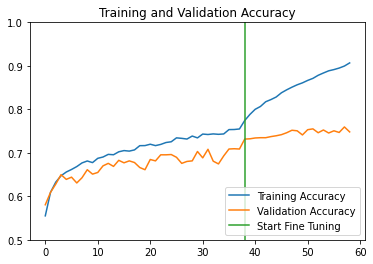

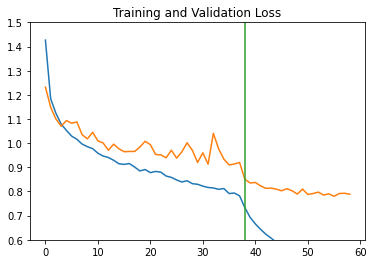

<Figure size 432x288 with 0 Axes>

In [77]:
%matplotlib inline
#print(history.history)

fine_acc= acc[:original_epochs] + history_fine.history['sparse_categorical_accuracy']
fine_val_acc = val_acc[:original_epochs] + history_fine.history['val_sparse_categorical_accuracy']
fine_loss = loss[:original_epochs] + history_fine.history['loss']
fine_val_loss= val_loss[:original_epochs] + history_fine.history['val_loss']

#fine_acc= [0] * 8 + history_fine.history['sparse_categorical_accuracy']
#fine_val_acc = [0] * 8 + history_fine.history['val_sparse_categorical_accuracy']
#fine_loss = [0] * 8 +  history_fine.history['loss']
#fine_val_loss= [0] * 8 +  history_fine.history['val_loss']


epochs=range(len(fine_acc)) # Get number of epochs
#print(acc)

plt.plot(fine_acc, label='Training Accuracy')
plt.plot(fine_val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([original_epochs,original_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure()


plt.plot(fine_loss, label='Training Loss')
plt.plot(fine_val_loss, label='Validation Loss')
plt.ylim([0.6, 1.5])
plt.plot([original_epochs,original_epochs],
         plt.ylim(), label='Start Fine Tuning')
#plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.figure()